# Mastering PEFT: A Deep Dive into LoRA from Scratch

**Objective:** This notebook provides a comprehensive exploration of **Parameter-Efficient Fine-Tuning (PEFT)** by implementing the **Low-Rank Adaptation (LoRA)** technique from scratch in PyTorch. We demonstrate its power and efficiency by fine-tuning a pre-trained text classifier and comparing its performance against a traditional training approach.

---

### Methodology & Core Concepts

This project breaks down LoRA from theory to practical application in a few key steps:

1.  **Baseline Model:** A standard text classification model is trained from scratch on the **IMDB Movie Reviews** dataset to establish a performance benchmark.
2.  **Theory of Low-Rank Adaptation:** We visually and mathematically explore the concept of matrix rank, the core principle that makes LoRA efficient.
3.  **LoRA Layers from Scratch:** We build the `LoRALayer` and `LinearWithLoRA` modules ourselves, showing exactly how the low-rank matrices ($A$ and $B$) are created and integrated into a frozen linear layer.
4.  **PEFT in Action:** We apply our custom LoRA layers to a model pre-trained on the **AG News** dataset, fine-tuning it for the IMDB sentiment analysis task by only training the lightweight LoRA weights.
5.  **Generalization:** We demonstrate the versatility of LoRA by applying it to a completely different architecture—a Convolutional Neural Network (`NNet`).

---

### Key Findings & Conclusion

The results clearly highlight the dual benefits of LoRA: **improved performance and massive parameter efficiency.**

| Training Method | Test Accuracy (IMDB) | Parameter Efficiency |
| :--- | :---: | :--- |
| Trained from Scratch | ~66.2% | Trains all parameters (~12,800 in the dense layer). |
| **Fine-Tuned with LoRA** | **~69.2%** | **Trains only the LoRA weights (~450 parameters).** |

By fine-tuning with LoRA, we achieved a **3% absolute improvement in accuracy** while training **~28 times fewer parameters** in the adapted layer. This demonstrates that LoRA is a highly effective and efficient technique for adapting large pre-trained models to new tasks.

- **Datasets:** `AG News` (for pre-training), `IMDB Movie Reviews` (for fine-tuning).
- **Core Libraries:** `PyTorch`, `TorchText`.

In [2]:
# !pip install torch==2.2.2
# !pip install torchtext==0.17.2
# !pip install portalocker==2.8.2
# !pip install torchdata==0.7.1
# !pip install pandas
# !pip install matplotlib==3.9.0 scikit-learn==1.5.0
# !pip install numpy==1.26.0

In [3]:
import io
import math
import os
import pickle
import tarfile
import tempfile
import warnings
from itertools import accumulate
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

import torchtext
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torchtext.datasets import AG_NEWS
from torchtext.vocab import GloVe, Vectors, build_vocab_from_iterator


def warn(*args, **kwargs):
    """Custom warn function to suppress output."""
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

In [4]:
def plot(COST, ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

    plt.show()

In [5]:
def save_list_to_file(lst, filename):
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

## Data pipeline


In [6]:
tokenizer = get_tokenizer("basic_english")

In [7]:
def yield_tokens(data_iter):
    for  _, text in data_iter:
        yield tokenizer(text)

In [8]:
glove_embedding = GloVe(name="6B", dim=100)

In [9]:
vocab = vocab(glove_embedding .stoi, min_freq=0, specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [10]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) 

## IMDB dataset 


In [11]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

In [19]:
print(tempdir.name)
print(os.listdir(tempdir.name))
print(os.listdir(tempdir.name + '/' + 'imdb_dataset'))
print(os.listdir(tempdir.name + '/' + 'imdb_dataset/train'))
print(os.listdir(tempdir.name + '/' + 'imdb_dataset/train/pos')[:10])

/tmp/tmptqn2hay8
['imdb_dataset']
['test', 'train', '.DS_Store']
['pos', '.DS_Store', 'neg']
['9473_10.txt', '9890_8.txt', '542_9.txt', '7716_9.txt', '8582_9.txt', '4654_7.txt', '2706_9.txt', '8504_8.txt', '11710_10.txt', '2184_7.txt']


In [20]:
class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            
        return label, content

In [21]:
root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  
test_iter = IMDBDataset(root_dir=root_dir, train=False)  

In [22]:
start = train_iter.pos_inx
start = 0
for i in range(-2, 2):
    print(train_iter[start+i])
    print('=' * 100)

(1, "Have to be honest and say that I haven't seen many independent films, but I thought this one was very well done. The direction and cinematography were engaging without becoming a distraction. The angles, settings, and lighting used successfully created the nightmarish world in which the main character was trapped. Many haunting and memorable images from the film stick in your mind long after it's over (always a sign of a good director).")
(1, "What surprised me most about this film was the sheer audience it attracted. Similar films such as Anita and Me have never caused as much hype as this film has, though I think that's probably because of the mention of 'Beckham' in the title more than anything else.<br /><br />It's a brilliant film putting across a brilliant message - you can do anything if you're determined enough, and put your mind to it, which is such a positive message to anyone watching this film.<br /><br />I think this is one of Keira Knightley's better films, and I thi

In [47]:
imdb_label = {0: "negative review", 1: "positive review"}
imdb_label[1]

'positive review'

In [48]:
set([label for (label, text) in train_iter ])

{0, 1}

In [49]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

2

In [50]:
vocab(["age", "hello"])

[466, 13077]

### Train and validate


In [51]:
# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [52]:
print(len(test_dataset))
print(len(split_train_))
print(len(split_valid_))

25000
23750
1250


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader


In [54]:
def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

In [55]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [56]:
label, seqence = next(iter(valid_dataloader ))
label, seqence

(tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
         1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]),
 tensor([[    39,     16,      9,  ...,      0,      0,      0],
         [    51,      2, 270328,  ...,      0,      0,      0],
         [    43,   1908,     39,  ...,      0,      0,      0],
         ...,
         [   110,  15612,     35,  ...,      0,      0,      0],
         [   176,    533,      2,  ...,      5,     22,      4],
         [   203,    525,   1332,  ...,      0,      0,      0]]))

In [57]:
print(label.shape)
print(seqence.shape)

torch.Size([64])
torch.Size([64, 968])


### Neural network


In [58]:
class TextClassifier(nn.Module):
    def __init__(self, num_classes, freeze=False):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_embedding.vectors.to(device), freeze=freeze)
        self.fc1 = nn.Linear(in_features=100, out_features=128)
        self.relu = nn.ReLU()
        # The output layer that gives the final probabilities for the classes
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

## Train the model on the full dataset

The model can then be trained on labeled data from the IMDB dataset with two classes.

In [59]:
model = TextClassifier(num_classes=2, freeze=True)
model.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [60]:
model.eval()
predicted_label = model(seqence)

In [61]:
print(predicted_label.shape)

torch.Size([64, 2])


In [62]:
def predict(text, model, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)), 0).to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [63]:
predict("the is a good movie", model, text_pipeline )

'negative review'

In [64]:
def evaluate(dataloader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            outputs = model(text)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [65]:
evaluate(test_dataloader, model, device)

50.0

performance of the model is no better than average. This outcome is expected, considering that the model has not undergone any training yet.


## Train the model

In [72]:
def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=100, model_name="model-imdb-freeze-true2"):
    cum_loss_list = []
    acc_epoch = []
    best_acc = 0
    file_name = model_name
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        cum_loss = 0
        for _, (label, text) in enumerate(train_dataloader):            
            optimizer.zero_grad()
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
            
        cum_loss_list.append(cum_loss)
        acc_val = evaluate(valid_dataloader, model, device)
        acc_epoch.append(acc_val)
        
        if acc_val > best_acc:
            best_acc = acc_val
            print(f"New best accuracy: {acc_val:.4f}")
            #torch.save(model.state_dict(), f"{model_name}.pth")
    
    #save_list_to_file(cum_loss_list, f"{model_name}-loss.pkl")
    #save_list_to_file(acc_epoch, f"{model_name}-acc.pkl")

In [73]:
LR = 1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

I have pretrained the model for 300 epochs using a GPU and saved this model.

In [74]:
# model_name = "model-imdb-freeze-true2"
# train_model(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)

let's load the pretrained model that was trained for 300 epochs


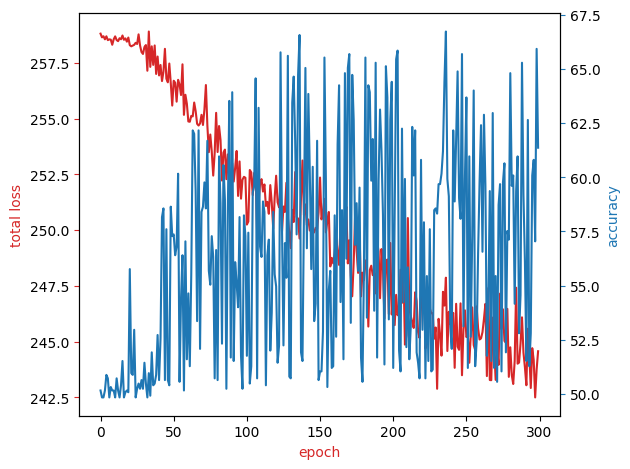

In [75]:
model_name = "model-imdb-freeze-true2"

cum_loss_list = load_list_from_file(model_name + "-loss.pkl")
acc_epoch = load_list_from_file(model_name + "-acc.pkl")
plot(cum_loss_list, acc_epoch)

In [76]:
model.load_state_dict(torch.load(model_name + ".pth", map_location=device))
model.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [77]:
evaluate(test_dataloader , model, device)

66.24

The pretrained model achieves an accuracy of 66%.

---
---
---

##  Low-Rank Adaptation (LoRA)

We delve into building a LoRA (Low-Rank Adaptation) implementation from scratch using PyTorch. LoRA is a general method, but it's commonly applied to the Attention layer. For the sake of simplicity, we apply it to a Vanilla neural network.

### LoRA

$ W_1\approx W_0 + \Delta  W = W_0 + BA $

    To train and predict, the forward pass holds $W_0$ constant.

$h = W_0 + \Delta W  = W_0x + BAx $

### Rank
The rank of a matrix is the number of dimensions the rows of the matrix "live in."  A square matrix is said to be **full rank** if its rank is equal to the number of its rows or columns.

In [98]:
from sympy import Matrix, init_printing, Symbol
from numpy.linalg import qr, eig, inv, matrix_rank, norm
from scipy.linalg import null_space
init_printing()

In [99]:
def plot_matrix_and_subspace(F):
    assert F.shape[0] == 3, "Matrix F must have 3 rows to represent 3D space."

    ax = plt.figure().add_subplot(projection='3d')
    
    # Plot each column vector of F
    for i in range(F.shape[1]):
        ax.quiver(0, 0, 0, F[0, i], F[1, i], F[2, i], color='blue', arrow_length_ratio=0.1, label=f'Column {i+1}')

    # Calculate the null space of the transpose of F
    normal_vector = null_space(F.T)
    
    # Check that the null space is 1-dimensional
    if normal_vector.shape[1] == 1:
        normal_vector = normal_vector[:, 0]  # Simplify the array to 1D
        # Create a meshgrid for the plane
        xx, yy = np.meshgrid(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10))
        # Calculate corresponding z coordinates based on the plane equation ax + by + cz = 0
        zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2] if normal_vector[2] != 0 else 0
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Spanned Plane')
    else:
        print("The null space is not 1-dimensional, so a unique plane cannot be determined.")

    # Set plot limits and labels
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()

    plt.show()

In [100]:
B = torch.tensor([[1,0], [0,1], [0,0]]).numpy()
Matrix(B)

⎡1  0⎤
⎢    ⎥
⎢0  1⎥
⎢    ⎥
⎣0  0⎦

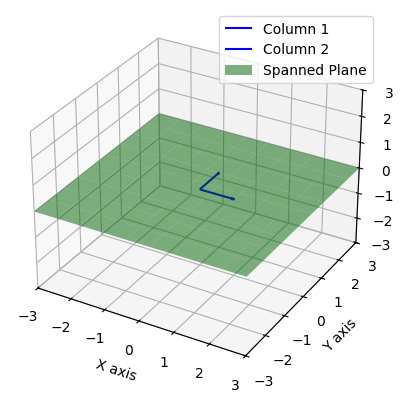

In [101]:
plot_matrix_and_subspace(B)

In this scenario, the vectors, despite each having three components, can reach any point on the two-dimensional green plane depicted in the image. These vectors span the green plane, which resides within a two-dimensional subspace. This subspace's dimension, also known as its 'rank', is two—corresponding to the dimensionality of the plane. If the rank were three, any point in the 3D space could be reached by some combination of the columns of $𝐵$. The rank of a matrix can be determined by using the matrix_rank function provided by NumPy.


In [102]:
matrix_rank(B)

2

Here, we plot a different matrix where the matrix spans a different plane, but the rank remains two.

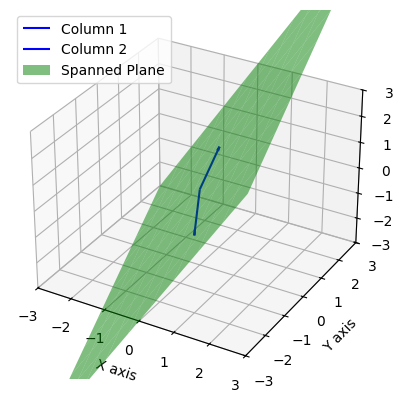

rank of B 2


In [103]:
B_= torch.tensor([[1,0], [-2,1], [0,1]]).numpy()
plot_matrix_and_subspace(B_)
print("rank of B", matrix_rank(B_))

Here,we present the matrix ```A```. The rank of this matrix is also two.

In [104]:
A = torch.tensor([[1, 1, -1, 1, 0], [-2, 2, 2, 0, 1]]).numpy()
Matrix(A)

⎡1   1  -1  1  0⎤
⎢               ⎥
⎣-2  2  2   0  1⎦

In [105]:
matrix_rank(A)

2

For the matrices $ C = BA $, if $B $ and $ A $ both have a rank of $ r $:


In [106]:
C = B @ A
Matrix(C)

⎡1   1  -1  1  0⎤
⎢               ⎥
⎢-2  2  2   0  1⎥
⎢               ⎥
⎣0   0  0   0  0⎦

 The columns of $ C $ will have the same rank as $ B $. Furthermore, the span of the columns of $ C $ will be the same as the span of the columns of $ B $.


rank of C 2


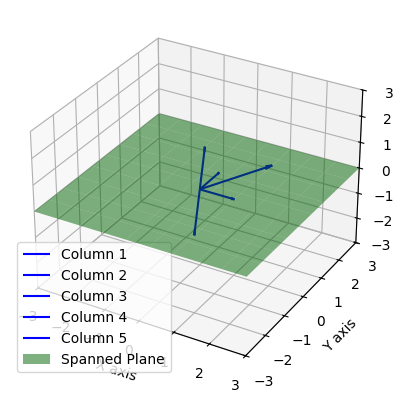

In [107]:
print("rank of C", matrix_rank(C))
plot_matrix_and_subspace(C)

### LoRA in PyTorch

In [111]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha


    # x @ self.A: The input x [batch_size, in_dim] (shape [in_dim, rank]), resulting in a tensor of shape [batch_size, rank].
    # @ self.B: resulting in a tensor of shape [batch_size, out_dim].
    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

This class ```LinearWithLoRA```  copies the original linear model and creates a ```LoRALayer``` object. 

Then, in the forward method apply both the original linear model and the output Lora model to the input x and add them together ```self.linear(x) + self.lora(x)```. This corresponds to:

 $xW_0 + xAB $

In [113]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear.to(device)
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)

    def forward(self, x):
        # W'x = W₀x + ΔWx
        return self.linear(x) + self.lora(x)

### Applying LoRA
To fine-tune with LoRA, first, load a pretrained TextClassifier model with LoRA (while freezing its layers), load its pretrained state from a file, and then disable gradient updates for all of its parameters to prevent further training. Here, we will load a model that was pretrained on the AG NEWS dataset, which is a dataset that has 4 classes. we initialize this model, we set `num_classes` to 4. Moreover, the pretrained AG_News model was trained with the embedding layer unfrozen. Hence we will initialize the model with `freeze=False`. Although we are initializing the model with layers unfrozen and the wrong number of classes for our task, we will make modifications to the model later on that to correct this:

In [114]:
model_lora = TextClassifier(num_classes=4, freeze=False)
model_lora.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [116]:
state_dict = torch.load("my-model-agnews-freeze-false.pth", map_location=device)
model_lora.load_state_dict(state_dict)

<All keys matched successfully>

In [117]:
# Here, we freeze all layers:
for parm in model_lora.parameters():
    parm.requires_grad=False
    
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Additionally, the original model was on a classification problem that had four classes, while the IMDB dataset has just 2 classes. To account for this, we will replace the final layer with a new linear layer where the number of outputs equals 2:

In [118]:
model_lora.fc2 = nn.Linear(in_features=128, out_features=2, bias=True).to(device)
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [119]:
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

now replace the hidden layer with a LoRA layer. we can access the hidden layer as

In [120]:
model_lora.fc1

Linear(in_features=100, out_features=128, bias=True)

The following replaces this layer with a LoRA layer:


In [121]:
model_lora.fc1 = LinearWithLoRA(model_lora.fc1, rank=2, alpha=0.1).to(device)

Let's look at the hidden layer again to ensure that it is indeed converted to a LoRA layer.


In [122]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

In [123]:
for name, param in model_lora.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

embedding.weight: requires_grad=False
fc1.linear.weight: requires_grad=False
fc1.linear.bias: requires_grad=False
fc1.lora.A: requires_grad=True
fc1.lora.B: requires_grad=True
fc2.weight: requires_grad=True
fc2.bias: requires_grad=True


At this point, training the model is similar, with the only difference being that, except for the output layer, only the learnable parameters 
```A``` and  ```B``` will be updated. The code to select the values for  `r` and `alpha`, which is not run, is nonetheless provided herein for your convenience.


In [124]:
model_lora.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Let's set up the training components for the `model_lora` model

In [125]:
LR = 1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lora.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

I have pretrained a model using an identical procedure for 300 epochs and saved it for reuse on a GPU.

In [128]:
# model_name = "model-lora-final2"
# train_model(model_lora,optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)

In [129]:
model_name = "model-lora-final2"

The following shows the progression of the training of this model for 300 epochs:


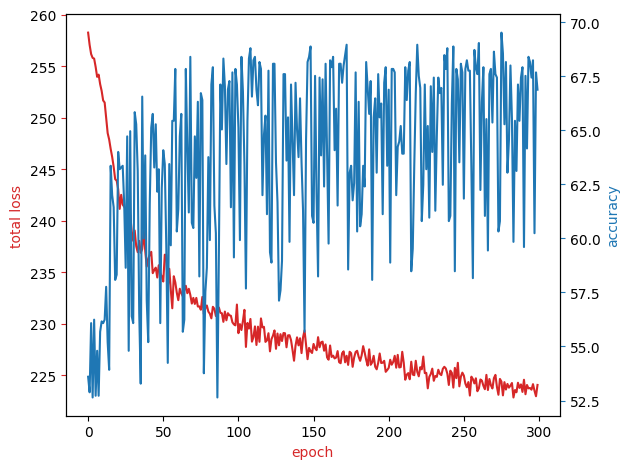

In [130]:
cum_loss_list=load_list_from_file(model_name+ "-loss.pkl")
acc_epoch=load_list_from_file(model_name + "-acc.pkl")
plot(cum_loss_list, acc_epoch)

Let's load the model into model_lora:


In [131]:
model_lora.load_state_dict(torch.load(model_name + ".pth", map_location=device))
model_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

 evaluate its performance on the test data.


In [132]:
evaluate(test_dataloader, model_lora, device)

we get a 3% improvement over a model trained from scratch by using LoRA. this occurs despite the fact that the model fine-tuned with LoRA updated less parameters than the model trained from scratch!

The ```model_lora.fc1``` attribute represents ```LinearWithLoRA``` which contains both the standard ```Linear``` layer ``(linear)`` and an additional ```LoRA``` layer ```(lora)``` which represents the ```LoRALayer```.


In [133]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

From ```model_lora.fc1.lora```, we can obtain the learnable parameters A and B.  


In [134]:
B = model_lora.fc1.lora.B
print("B", B)
print("\n Number of elements in the tensor B", B.numel())
torch.save(B, 'B.pth')

B Parameter containing:
tensor([[-4.3192e-01, -1.1071e+00,  2.4456e-01, -3.1031e-02, -2.0012e-01,
         -6.7811e-01, -1.3552e-01, -2.7458e-01,  3.2278e-02,  6.7592e-02,
          8.3020e-01,  1.1610e-05, -1.0894e-01,  7.7830e-05, -1.6789e-01,
         -1.3309e-01, -5.1875e-01,  2.1928e-02, -6.5869e-02, -3.5834e-01,
         -2.4473e-02, -1.1260e+00, -8.8752e-02, -7.0861e-03, -1.3263e-02,
          0.0000e+00, -6.9039e-01, -8.6471e-02, -3.9146e-01, -2.2644e-01,
         -8.7611e-01, -7.9929e-01,  0.0000e+00,  3.9646e-01,  5.2164e-01,
         -4.2730e-01,  2.3550e-01,  4.0447e-02,  2.3289e-01, -4.5217e-01,
          1.7721e-03, -4.7263e-01, -2.4343e-01,  6.3737e-01,  0.0000e+00,
          2.6904e-03, -7.8828e-01,  2.2559e-02, -4.3776e-02,  3.0909e-01,
         -1.6914e-01, -2.0294e-01, -4.2175e-01,  7.8840e-01, -3.1771e-01,
         -2.0639e-01,  1.1487e-02, -5.7238e-01,  1.4071e-01, -2.8561e-01,
          1.1753e-01, -1.6501e-04, -4.5406e-01,  0.0000e+00,  6.4464e-05,
         -4.45

In [135]:
A = model_lora.fc1.lora.A
print("A", A)
print("\n Number of elements in the tensor A", A.numel())
torch.save(A, 'A.pth')

A Parameter containing:
tensor([[ 3.2952e-01,  9.3019e-01],
        [ 2.3904e+00, -5.1022e+00],
        [-2.4573e-01,  2.4733e+00],
        [ 5.8014e-01,  3.9014e-01],
        [ 1.6970e+00, -2.4614e+00],
        [-1.2420e+00,  8.3014e-01],
        [-2.0468e+00,  1.1629e+00],
        [-5.9361e-01,  1.8099e-01],
        [ 9.2466e-02,  1.1583e-01],
        [-2.0841e-02,  1.5550e+00],
        [ 1.3028e+00, -9.8381e-01],
        [ 1.4320e+00, -3.3497e+00],
        [-1.1637e+00,  1.9436e+00],
        [ 2.4898e-01, -1.1353e+00],
        [ 2.4423e+00,  1.0154e+00],
        [ 2.4881e+00, -4.6765e+00],
        [-1.8985e-01,  1.3426e+00],
        [-1.1730e-01, -2.1925e+00],
        [ 2.0193e+00, -8.5886e-01],
        [-3.1268e+00,  3.5134e+00],
        [ 1.0935e+00, -2.9263e+00],
        [-1.0435e+00,  2.5428e-01],
        [-8.6704e-01,  2.3570e+00],
        [-5.2725e-02, -2.3731e-01],
        [-4.3896e+00,  5.0369e+00],
        [-1.1174e+00,  9.9728e-01],
        [ 4.7710e-01, -1.2162e+00],
    

A and B have approximately 450 parameters. If we were to store the entire linear layer, we would have 12,800 parameters, which is around 28 times more.

In [136]:
print("\n Number of elements in the tensor A", model_lora.fc1.linear.weight.numel())


 Number of elements in the tensor A 12800


 alfa and the ouput layer  are also saved.


In [137]:
alfa_= model_lora.fc1.lora.alpha
torch.save(alfa_, 'alfa_.pth')
torch.save(model_lora.fc2.state_dict(), 'out_layer.pth')

## Loading the model

The main advantage of LoRA is that for fine-tuning, we only need to save the learnable parameters A and B, alpha, and the output layer in our classification example.

The saved files are converted to tensors and the linear layer, respectively.


In [138]:
A = torch.load('A.pth')
print("A:", A.shape)

A: torch.Size([100, 2])


In [139]:
B = torch.load('B.pth')
print("B:", B.shape)

B: torch.Size([2, 128])


In [140]:
alfa_ = torch.load('alfa_.pth')
alfa_ 

The output layer:


In [141]:
output_layer = nn.Linear(in_features=128, out_features=2, bias=True)
output_layer.load_state_dict(torch.load('out_layer.pth'))

<All keys matched successfully>

The model object is created and the pretrained parameters are loaded:


In [142]:
model_load_lora = TextClassifier(num_classes=4, freeze=False)
model_load_lora.to(device)

state_dict = torch.load('my-model-agnews-freeze-false.pth', map_location=device)
model_load_lora.load_state_dict(state_dict)
model_load_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

The LoRA layer object is added to the original hidden layer.


In [143]:
model_load_lora.fc1 = LinearWithLoRA(model_load_lora.fc1, rank=2, alpha=0.1)
model_load_lora.fc2 = nn.Linear(in_features=128, out_features=2, bias=True).to(device)

The parameters from fine-tuning are added.


In [144]:
model_load_lora.fc1.lora.A = A
model_load_lora.fc1.lora.B = B
model_load_lora.fc1.lora.alpha = alfa_ 
model_load_lora.fc2 = output_layer

In [145]:
model_load_lora.to(device)
model_load_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [146]:
evaluate(test_dataloader, model_load_lora, device)

This confirms that the model loaded correctly. we still get a 3% improvement in accuracy!

Finally, the following shows how we can make a prediction on the following article using the function **`predict`**:

In [147]:
article = """This was a lacklustre movie with very little going for it. I was not impressed."""

In [148]:
result = predict(article, model_load_lora, text_pipeline)
result

'negative review'

## Applying LoRA to a different network

The following code defines a neural network called `NNet`. 

`NNet` is a neural network that was originally written to identify hand-written digits from 32x32 images. our task is to fine-tune this network to perform letter recognition using LoRA. apply LoRA to just the second linear layer, and replace the last layer with a layer that has 26 outputs, one for each letter in the English alphabet.

In [149]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output

model = NNet()
model.to(device)

print('This is what the model looked like before applying LoRA:')
print(model)
print("\n###############\n")

# Freeze all parameters:
for parm in model.parameters():
    parm.requires_grad = False

# Change final layer for one with 26 outputs:
model.fc3 = nn.Linear(in_features=84, out_features=26, bias=True).to(device)

# Apply LoRA to the second linear layer
model.fc2=LinearWithLoRA(model.fc2, rank=2, alpha=0.1).to(device)

print('This is what the model looked like after applying LoRA:')
print(model)

This is what the model looked like before applying LoRA:
NNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

###############

This is what the model looked like after applying LoRA:
NNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): LinearWithLoRA(
    (linear): Linear(in_features=120, out_features=84, bias=True)
    (lora): LoRALayer()
  )
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)
